# Dimensionality reduction on epochs

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --Machine learning and statistics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from scipy import stats
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.utils import resample

# Image processing
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import cv2

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [7]:
data_path = prefix + 'representation_learning_variability/paper-individuality/clustering/'
all_sequences = pd.read_parquet(data_path+'all_sequences_09-29-2025')


## Get sequences per epoch

In [8]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [21]:
epoch_sequences = np.vstack(all_sequences['binned_sequence'])  # Transpose to get the right shape

use_mat = pd.DataFrame(epoch_sequences)
use_mat['epoch'] = pd.factorize(all_sequences['broader_label'])[0]
named_labels = all_sequences['broader_label']

## Separate states per variable (one-hot encoding)

In [33]:
use_sequences = epoch_sequences

use_states = int(max(np.unique(epoch_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

In [34]:
final_matrix = binarized.copy()

([<matplotlib.axis.XTick at 0x7fdda75af850>,
 [Text(0, 0, '0'), Text(160, 0, '160')])

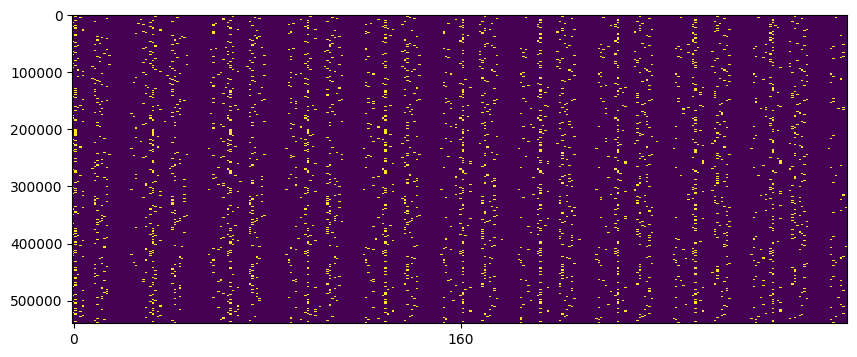

In [35]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(final_matrix), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

# PCA

In [64]:
n_components = 300
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
standardized_X = scaler.fit_transform(final_matrix)
X_pca = pca.fit_transform(standardized_X)
# X_pca = pca.fit_transform(final_matrix)

Text(0.5, 1.0, 'Explained Variance by PCA')

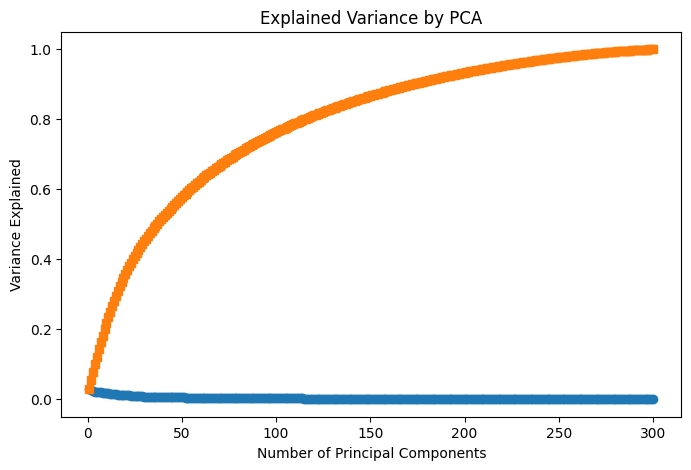

In [65]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

# UMAP

In [68]:
ori_X = X_pca.copy()
# ori_X = final_matrix.copy()

In [69]:
reducer = umap.UMAP(random_state= 42, n_components=2)
# reducer = umap.UMAP(n_components=2)

embedding = reducer.fit_transform(ori_X)
# embedding = reducer.fit_transform(X_pca)
embedding.shape

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 53 with accuracies 
[6.48877635e-07 1.66583085e-06 2.38764050e-04 9.93591434e-05]
not reaching the requested tolerance 1.8924474716186523e-06.
Use iteration 53 instead

KeyboardInterrupt: 

In [40]:
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.segmentation import find_boundaries
from skimage.morphology import disk


In [41]:
def plot_kde(X_embedded, kernel, xmin, xmax, ymin, ymax, res):
    X, Y = np.mgrid[xmin:xmax:res, ymin:ymax:res]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
            extent=[xmin, xmax, ymin, ymax], aspect='auto')
    ax.plot(X_embedded[:, 0], X_embedded[:, 1], 'k.', 
            markersize=.1, alpha=.1)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')

    plt.show()

    return Z

def points_to_pixels(points, xmin, xmax, ymin, ymax, nx, ny):
    px = ((points[:, 0] - xmin) / (xmax - xmin) * (nx - 1)).astype(int)
    py = ((points[:, 1] - ymin) / (ymax - ymin) * (ny - 1)).astype(int)

    px = np.clip(px, 0, nx - 1)
    py = np.clip(py, 0, ny - 1)

    return px, py

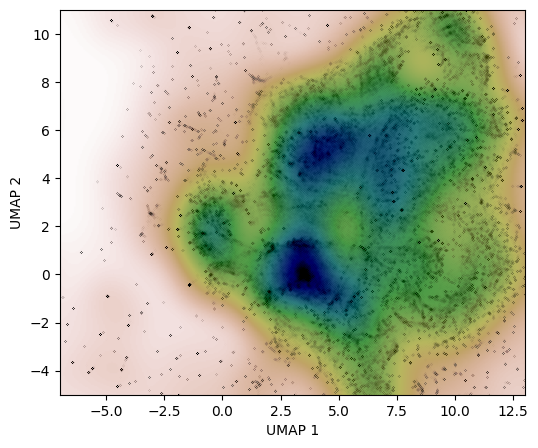

In [42]:
""" Perform Gaussian kde """
values = embedding.T.copy()
kernel = stats.gaussian_kde(values)

xmin = -7
xmax = 13
ymin=-5
ymax=11
Z = plot_kde(embedding, kernel, xmin, xmax, ymin, ymax, res=300j)

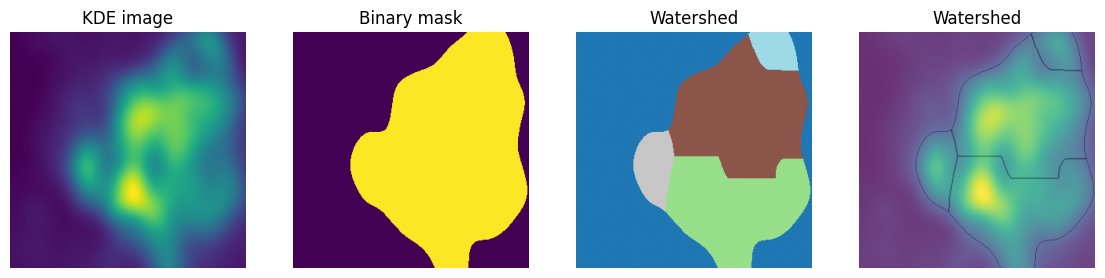

In [45]:
image = Z.copy()
# image = gaussian(image, sigma=.5)

binary = image > np.percentile(image, 50)
binary = ndi.binary_fill_holes(binary)

coords = peak_local_max(
    image,
    footprint=disk(1),
    min_distance=1,
    labels=binary)
markers = np.zeros(image.shape, dtype=int)
markers[tuple(coords.T)] = np.arange(1, len(coords) + 1)

labels = watershed(-image, markers, mask=binary)

boundaries = find_boundaries(labels, mode="outer")

fig, ax = plt.subplots(1, 4, figsize=(14, 4))
ax[0].imshow(np.rot90(Z))
ax[0].set_title("KDE image")
ax[1].imshow(np.rot90(binary))
ax[1].set_title("Binary mask")
ax[2].imshow(np.rot90(labels), cmap="tab20")
ax[2].set_title("Watershed")
ax[3].imshow(np.rot90(image))
ax[3].imshow(np.rot90(boundaries), cmap="Reds", alpha=0.2)
ax[3].set_title("Watershed")
for a in ax:
    a.axis("off")
plt.show()

In [56]:
epoch_number = pd.factorize(named_labels)[0]
cmap = plt.get_cmap("tab10")
clusters = np.unique(epoch_number)
color_dict = {
    k: cmap(k % cmap.N)   # exact tab20 color
    for k in clusters}
scatter_colors = np.array([color_dict[k] for k in epoch_number])
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     color=scatter_colors, #c=point_labels,
#     cmap="tab20",
#     s=2, alpha=.1)
# plt.imshow(np.rot90(boundaries), cmap=plt.cm.gist_earth_r,
#         extent=[xmin, xmax, ymin, ymax], aspect='auto')
# plt.axis("off")
# plt.show()

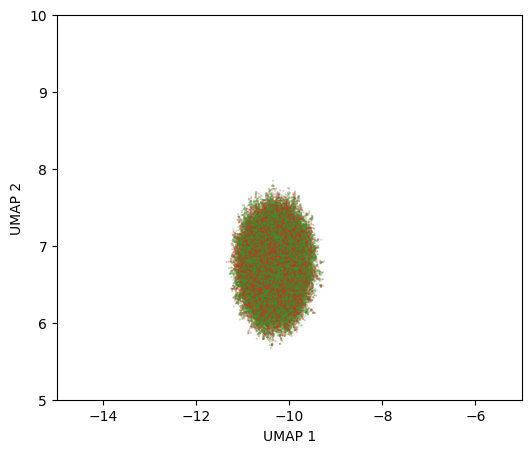

In [63]:
fig, ax = plt.subplots(figsize=(6, 5))
xmin = -15
xmax = -5
ymin=5
ymax=10
ax.scatter(embedding[:, 0], embedding[:, 1], color=scatter_colors, alpha=.5, s=.1) #'k.',
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

plt.show()

In [67]:
data_path = prefix + 'representation_learning_variability/paper-individuality/clustering/'
np.save(data_path+'epoch_umap_no_standardiz', embedding)
# embedding.to_parquet(data_path+'epoch_umap_no_standardiz',compression='gzip') 